# Monet-Style GANs

### This notebook contains a GAN model to alter photos to take on the style of Monet.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
tf.config.run_functions_eagerly(True)

## Data is downloaded from kaggle. Will start by reading in the file names

In [2]:
monet_dir = 'monet_tfrec/'
photo_dir = 'photo_tfrec/'

monet_filenames = [os.path.join(monet_dir, f) for f in os.listdir(monet_dir)]
photo_filenames = [os.path.join(photo_dir, f) for f in os.listdir(photo_dir)]

#### Check how many images are in the dataset

In [3]:
print('Number of Monet Images:',len(monet_filenames))
print('Number of Photos:',len(photo_filenames))
print('monet filenames:', monet_filenames)

Number of Monet Images: 5
Number of Photos: 20
monet filenames: ['monet_tfrec/monet00-60.tfrec', 'monet_tfrec/monet08-60.tfrec', 'monet_tfrec/monet04-60.tfrec', 'monet_tfrec/monet12-60.tfrec', 'monet_tfrec/monet16-60.tfrec']


#### Photos are in TFRec format. Read them in as a tf dataset for EDA and image viewing

In [4]:
monet_ds = tf.data.TFRecordDataset(monet_filenames)
photo_ds = tf.data.TFRecordDataset(photo_filenames)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


## Look at sample images

In [5]:
def look_at_images(dataset, n_images, dataset_name):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    for i,image in enumerate(dataset.take(n_images)):
        image = tf.io.parse_single_example(image, tfrecord_format)
        image = image['image']
        image = tf.image.decode_jpeg(image, channels=3)

        plt.subplot(1, n_images, i+1)
        plt.imshow(image.numpy().astype("uint8"))
        plt.title(dataset_name)
        plt.axis("off")
    plt.show()


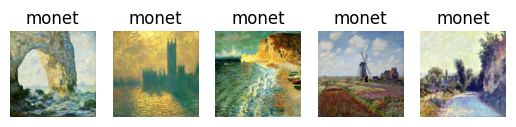

In [6]:
look_at_images(monet_ds, 5, 'monet')

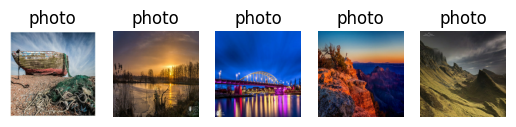

In [7]:
look_at_images(photo_ds, 5, 'photo')

## Image Processing
#### Create datasets for model training. Clean up images, make sure they are all the same size (256,256), normalize to -1,1

In [8]:
def parse_tfrecord_fn(example):
    tfrecord_format = {
    "image_name": tf.io.FixedLenFeature([], tf.string),
    "image": tf.io.FixedLenFeature([], tf.string),
    "target": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, tfrecord_format)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = tf.cast(image, tf.float32) / 127.5-1

    return image

def create_dataset(filenames, batch_size=1):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord_fn, num_parallel_calls=tf.data.AUTOTUNE)
    # dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
monet_ds = create_dataset(monet_filenames)
photo_ds = create_dataset(photo_filenames)
monet_ds = monet_ds.shuffle(1000).batch(1).prefetch(tf.data.AUTOTUNE)
photo_ds = photo_ds.shuffle(1000).batch(1).prefetch(tf.data.AUTOTUNE)

## Start Building Model
#### Start with Generator

In [10]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, LeakyReLU, Input, Dense, Flatten, Dropout, Reshape, Conv2DTranspose, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

def build_generator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)

        layer = Sequential()
        layer.add(Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))

        if apply_batchnorm:
            layer.add(BatchNormalization())

        layer.add(LeakyReLU())

        return layer

    def upsample(filters, size, apply_dropout=False):
        """Upsampling block for the generator"""
        initializer = tf.random_normal_initializer(0., 0.02)

        layer = Sequential()
        layer.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                                  kernel_initializer=initializer, use_bias=False))

        layer.add(BatchNormalization())

        if apply_dropout:
            layer.add(Dropout(0.5))

        layer.add(LeakyReLU())

        return layer

    # Input layer
    inputs = Input(shape=[256, 256, 3])

    # Downsampling path
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
    ]

    # Upsampling path
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                          kernel_initializer=initializer, activation='tanh')

    # Build the model using functional API for skip connections
    x = inputs

    # Downsampling and save the outputs for skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs=inputs, outputs=x)

def build_discriminator():
    def downsample(filters, size, apply_batchnorm=True):
        initializer = tf.random_normal_initializer(0., 0.02)

        layer = Sequential()
        layer.add(Conv2D(filters, size, strides=2, padding='same',
                          kernel_initializer=initializer, use_bias=False))

        if apply_batchnorm:
            layer.add(BatchNormalization())

        layer.add(LeakyReLU())

        return layer

    discriminator = Sequential(
    [
        Input(shape=(256, 256, 3)),
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        Conv2D(512, kernel_size=4, strides=2, padding="valid"),
        BatchNormalization(),
        LeakyReLU(),
        Conv2D(128, kernel_size=4, strides=2, padding="same"),
        LeakyReLU(),
        Flatten(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
    )

    return discriminator



In [11]:
class CGAN(tf.keras.Model):
    def __init__(self, monet_discriminator, monet_generator, photo_discriminator, photo_generator):
        super().__init__()
        self.m_disc = monet_discriminator
        self.m_gen = monet_generator
        self.p_disc = photo_discriminator
        self.p_gen = monet_generator
        self.seed_generator = tf.random.set_seed(1337)
        self.lambda_cycle = 10

    def compile(self, monet_disc_optimizer, monet_gen_optimizer, photo_disc_optimizer, photo_gen_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super().compile()
        self.m_d_opt = monet_disc_optimizer
        self.m_g_opt = monet_gen_optimizer
        self.p_d_opt = photo_disc_optimizer
        self.p_g_opt = photo_gen_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        self.m_d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.m_g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        self.p_d_loss_metric = tf.keras.metrics.Mean(name='d_loss')
        self.p_g_loss_metric = tf.keras.metrics.Mean(name='g_loss')
        self.cycle_loss_metric = tf.keras.metrics.Mean(name='cycle_loss')
        self.identity_loss_metric = tf.keras.metrics.Mean(name='identity_loss')

    @property
    def metrics(self):
        return [self.m_d_loss_metric, self.m_g_loss_metric, self.p_d_loss_metric, self.p_g_loss_metric, self.cycle_loss_metric, self.identity_loss_metric]

    def train_step(self, images):
        # Sample random points in the latent space
        real_monet, real_photo = images

        with tf.GradientTape(persistent=True) as tape:
            # Decode them to fake images
            fake_monet = self.m_gen(real_photo, training = True)
            cycled_photo = self.p_gen(fake_monet, training = True)

            fake_photo = self.p_gen(real_monet, training = True)
            cycled_monet = self.m_gen(fake_photo, training = True)

            same_monet = self.m_gen(real_monet, training = True)
            same_photo = self.p_gen(real_photo, training = True)

            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)

            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            m_gen_loss = self.gen_loss_fn(disc_fake_monet)
            p_gen_loss = self.gen_loss_fn(disc_fake_photo)

            total_cycle_loss = (
                self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) +
                self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            )

            total_identity_loss = (
                self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle) +
                self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)
            )

            total_m_gen_loss = m_gen_loss + total_cycle_loss + total_identity_loss
            total_p_gen_loss = p_gen_loss + total_cycle_loss + total_identity_loss

            m_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            p_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        m_gen_gradients = tape.gradient(total_m_gen_loss, self.m_gen.trainable_variables)
        p_gen_gradients = tape.gradient(total_p_gen_loss, self.p_gen.trainable_variables)

        m_disc_gradients = tape.gradient(m_disc_loss, self.m_disc.trainable_variables)
        p_disc_gradients = tape.gradient(p_disc_loss, self.p_disc.trainable_variables)

        self.m_g_opt.apply_gradients(
            zip(m_gen_gradients, self.m_gen.trainable_variables)
        )
        self.p_g_opt.apply_gradients(
            zip(p_gen_gradients, self.p_gen.trainable_variables)
        )

        self.m_d_opt.apply_gradients(
            zip(m_disc_gradients, self.m_disc.trainable_variables)
        )
        self.p_d_opt.apply_gradients(
            zip(p_disc_gradients, self.p_disc.trainable_variables)
        )

        # Update metrics
        self.m_d_loss_metric.update_state(m_disc_loss)
        self.m_g_loss_metric.update_state(m_gen_loss)
        self.p_d_loss_metric.update_state(p_disc_loss)
        self.p_g_loss_metric.update_state(p_gen_loss)
        self.cycle_loss_metric.update_state(total_cycle_loss)
        self.identity_loss_metric.update_state(total_identity_loss)

        return {
            "m_d_loss": self.m_d_loss_metric.result(),
            "m_g_loss": self.m_g_loss_metric.result(),
            "p_d_loss": self.p_d_loss_metric.result(),
            "p_g_loss": self.p_g_loss_metric.result(),
            'cycle_loss': self.cycle_loss_metric.result(),
            'identity_loss': self.identity_loss_metric.result()
        }


In [12]:
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [13]:
def generator_loss(generated):
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    return generated_loss

In [14]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [15]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))

    return LAMBDA * 0.5 * loss

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

def train_CGAN(monet_dataset, photo_dataset, callbacks, epochs=25):
    # Build the generators and discriminators
    monet_generator = build_generator()
    photo_generator = build_generator()
    monet_discriminator = build_discriminator()
    photo_discriminator = build_discriminator()

    # Create and compile the CycleGAN model
    CGAN_model = CGAN(
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
    )

    CGAN_model.compile(
        monet_gen_optimizer=tf.keras.optimizers.Adam(1e-3, beta_1=0.5, clipnorm=1.0),
        photo_gen_optimizer=tf.keras.optimizers.Adam(1e-3, beta_1=0.5, clipnorm=1.0),
        monet_disc_optimizer=tf.keras.optimizers.Adam(1e-3, beta_1=0.5, clipnorm=1.0),
        photo_disc_optimizer=tf.keras.optimizers.Adam(1e-3, beta_1=0.5, clipnorm=1.0),
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

    # Train the model
    history = CGAN_model.fit(
        tf.data.Dataset.zip((monet_dataset, photo_dataset)),
        epochs=epochs,
        callbacks = callbacks
    )

    return CGAN_model, history

In [17]:
model1, model1_hist = train_CGAN(monet_ds, photo_ds)

ValueError: A `Concatenate` layer requires inputs with matching shapes except for the concatenation axis. Received: input_shape=[(None, 2, 2, 512), (None, 1, 1, 512)]

#### Note- model 1 ran, and I accidentally tried to re-run it at one point after it had finished and stopped it because it takes too long to run a single model to re-run the same model again. The results below are accurate for the way model1 is set up above, ignore the error!

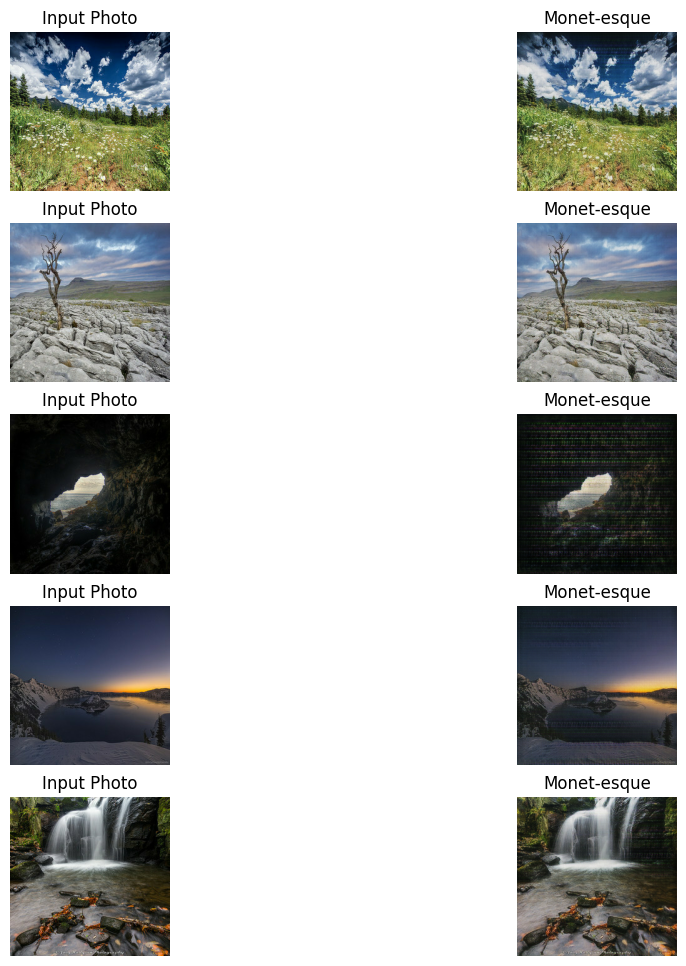

In [32]:
monet_gen = model1.m_gen

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

#### Not much change. Try some tuning - added more layers into both the upsample and downsample functions. Also increased learning rate to 1e-3.

In [48]:
model2, model2_hist = train_CGAN(monet_ds, photo_ds)

Epoch 1/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1488s 5s/step - cycle_loss: 4.6252 - identity_loss: 1.8799 - m_d_loss: 0.9975 - m_g_loss: 1.5329 - p_d_loss: 4.8820 - p_g_loss: 6.1581
Epoch 2/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


300/300 ━━━━━━━━━━━━━━━━━━━━ 1502s 5s/step - cycle_loss: 2.5710 - identity_loss: 0.8765 - m_d_loss: 0.6888 - m_g_loss: 1.1891 - p_d_loss: 4.3272 - p_g_loss: 4.0965
Epoch 3/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1517s 5s/step - cycle_loss: 2.0523 - identity_loss: 0.6819 - m_d_loss: 0.6764 - m_g_loss: 0.9304 - p_d_loss: 2.8999 - p_g_loss: 3.7598
Epoch 4/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1513s 5s/step - cycle_loss: 2.0612 - identity_loss: 0.6560 - m_d_loss: 0.7380 - m_g_loss: 1.1476 - p_d_loss: 2.5078 - p_g_loss: 3.4211
Epoch 5/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1515s 5s/step - cycle_loss: 1.9817 - identity_loss: 0.6158 - m_d_loss: 0.6294 - m_g_loss: 1.4624 - p_d_loss: 2.1348 - p_g_loss: 3.2553
Epoch 6/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1531s 5s/step - cycle_loss: 1.8716 - identity_loss: 0.5781 - m_d_loss: 0.6227 - m_g_loss: 1.1216 - p_d_loss: 1.5811 - p_g_loss: 3.0322
Epoch 7/25
300/300 ━━━━━━━━━━━━━━━━━━━━ 1540s 5s/step - cycle_loss: 1.6931 - identity_loss: 0.5224 - m_d_loss: 0.6115 - m_g_loss: 1.4329

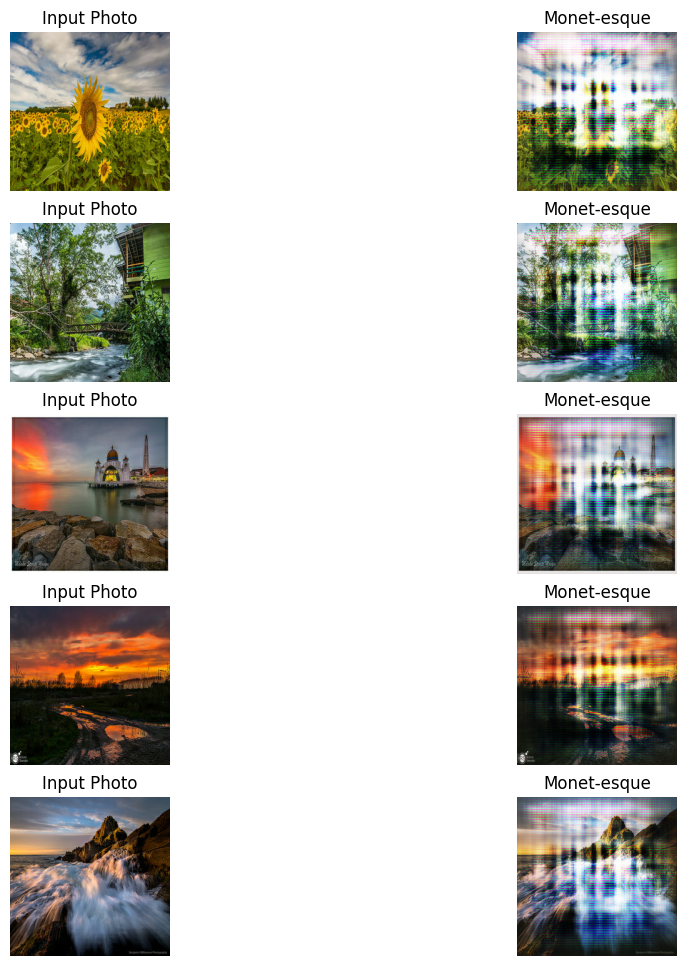

In [49]:
monet_gen = model2.m_gen

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### They look different, but definitely not like Monet. Will tune the discriminator by adding a few more layers to improve learning. Also adding a learning rate reduction function and gradient clipping to help the optimizer.

In [17]:
model3, model3_hist = train_CGAN(monet_ds, photo_ds, callbacks=[reduce_lr], epochs=30)

Epoch 1/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1560s 5s/step - cycle_loss: 3.8243 - identity_loss: 1.5585 - m_d_loss: 1.0951 - m_g_loss: 3.1582 - p_d_loss: 5.8369 - p_g_loss: 6.3132 - learning_rate: 0.0010
Epoch 2/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: cycle_loss,identity_loss,m_d_loss,m_g_loss,p_d_loss,p_g_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


300/300 ━━━━━━━━━━━━━━━━━━━━ 1596s 5s/step - cycle_loss: 2.2836 - identity_loss: 0.7791 - m_d_loss: 1.3810 - m_g_loss: 5.7331 - p_d_loss: 5.4948 - p_g_loss: 8.0939 - learning_rate: 0.0010
Epoch 3/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1568s 5s/step - cycle_loss: 2.2514 - identity_loss: 0.8590 - m_d_loss: 1.2930 - m_g_loss: 5.2870 - p_d_loss: 5.0346 - p_g_loss: 6.3519 - learning_rate: 0.0010
Epoch 4/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1537s 5s/step - cycle_loss: 2.2298 - identity_loss: 0.9886 - m_d_loss: 1.5138 - m_g_loss: 5.3672 - p_d_loss: 4.5046 - p_g_loss: 7.5352 - learning_rate: 0.0010
Epoch 5/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1540s 5s/step - cycle_loss: 2.6410 - identity_loss: 1.5421 - m_d_loss: 1.3248 - m_g_loss: 4.8092 - p_d_loss: 4.0450 - p_g_loss: 6.8179 - learning_rate: 0.0010
Epoch 6/30
300/300 ━━━━━━━━━━━━━━━━━━━━ 1530s 5s/step - cycle_loss: 2.1851 - identity_loss: 1.0638 - m_d_loss: 1.4092 - m_g_loss: 4.4072 - p_d_loss: 3.9504 - p_g_loss: 6.4281 - learning_rate: 0.0010
Epoch 7/30
300/3

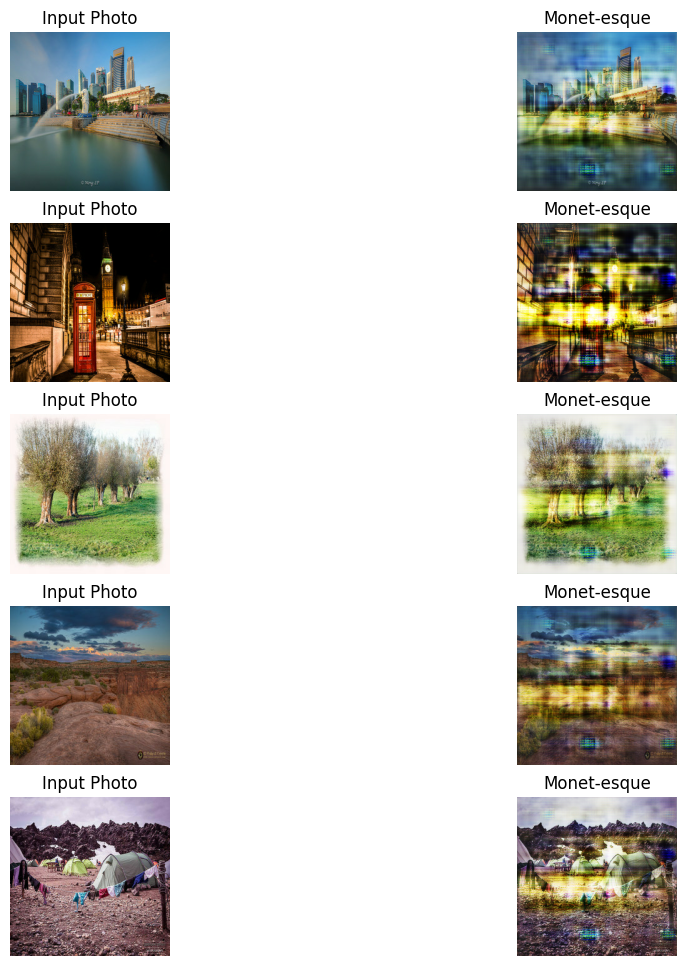

In [21]:
monet_gen = model3.m_gen

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

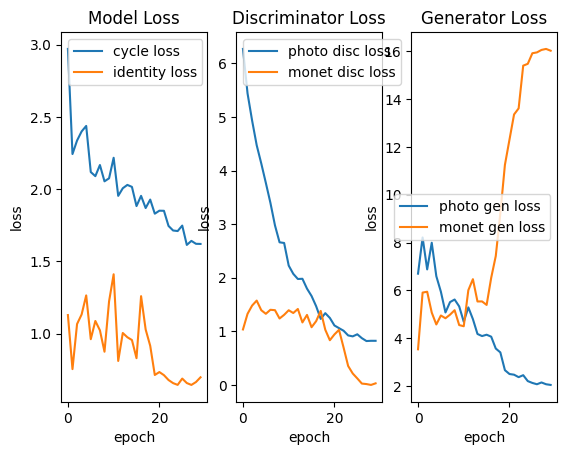

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.plot(model3_hist.history['cycle_loss'], label='cycle loss')
ax1.plot(model3_hist.history['identity_loss'], label='identity loss')
ax1.set_title('Model Loss')
ax1.legend()
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax2.plot(model3_hist.history['p_d_loss'], label='photo disc loss')
ax2.plot(model3_hist.history['m_d_loss'], label='monet disc loss')
ax2.set_title('Discriminator Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.legend()
ax3.plot(model3_hist.history['p_g_loss'], label='photo gen loss')
ax3.plot(model3_hist.history['m_g_loss'], label='monet gen loss')
ax3.set_title('Generator Loss')
ax3.set_xlabel('epoch')
ax3.set_ylabel('loss')
ax3.legend()
fig.show()

## Discussion and Conclusions

#### The final model definitely changed the photos, but it didn't really know what Monet's style was. With only 5 input Monet images, I think it was probably hard for the model to learn from such a small dataset.

#### Between the first and second model, I added more layers in the image generator function and increased the filter sizes. I think that definitely helped the generator function a lot better. In the third model, I added some layers to the discriminator and that also seemed to help a little, though the style was still very off. I think further improving the discriminator would be the next step. In the third model, I also added a learning rate reducer to help with model fitting, which seems to have helped a bit. This model could also be improved by further hyperparameter tuning. Due to run time constraints, not much hyperparameter tuning was done beyond adjusting the filter sizes. Optimizer tuning could have helped as well.

In [28]:
import PIL
os.makedirs("../images/", exist_ok=True)

In [29]:
i = 1
for img in photo_ds:
    prediction = monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [32]:
import zipfile

folder_to_zip = "../images/"
output_zip = "../images.zip"

with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_to_zip):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, os.path.dirname(folder_to_zip))
            zipf.write(file_path, arcname)